In [114]:
from PIL import Image
from wand.image import Image as wandImage
from wand.color import Color
from mrjob.job import MRJob
import cv2
import csv
import PyPDF2
import pytesseract
import argparse
import io
import numpy as np
import pandas as pd
import tempfile
import pickle
import boto3
import multiprocessing
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

def pdf_page_to_img(src_pdf, pagenum, resolution=300, preprocess="thresh"):

    dst_pdf = PyPDF2.PdfFileWriter()
    dst_pdf.addPage(src_pdf.getPage(pagenum))
    pdf_bytes = io.BytesIO()
    dst_pdf.write(pdf_bytes)
    pdf_bytes.seek(0)
    img_buffer=None

    with wandImage(file = pdf_bytes, resolution = resolution) as img:
        img.format = "png"
        img.alpha_channel = False
        img_buffer=np.asarray(bytearray(img.make_blob()), dtype=np.uint8)

    if img_buffer is not None:
        retval = cv2.imdecode(img_buffer, cv2.IMREAD_UNCHANGED)
        image = cv2.cvtColor(retval, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    if preprocess == "thresh":
        gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    elif preprocess == "blur":
        gray = cv2.medianBlur(gray, 3)

    return gray
    #return Image.fromarray(gray)

def categorizeTwoColumnBlocks(contents):
    blockstats = contents['blockstats']
    paragraphs = contents['paragraphs']
    data = contents['data']
    boxes = contents['boxes']
    
    header = blockstats[(blockstats.bottom_at < blockstats.bottom_at.max()*0.1) & (blockstats.n_par < 2)].sort_values(by='left_at')
    leftcol = blockstats[(blockstats.right_at < blockstats.right_at.max()*0.75) & (blockstats.n_par > 1)].sort_values(by='left_at')
    rightcol = blockstats[(blockstats.right_at > blockstats.right_at.max()*0.75) & (blockstats.n_par > 1)].sort_values(by='top_at')
    footer = blockstats[(blockstats.top_at > blockstats.bottom_at.max()*0.9) & (blockstats.n_par < 2)].sort_values(by='top_at')

    blocks = {'header':header,'footer':footer,'leftcol':leftcol,'rightcol':rightcol}

    paragraphs = {'header':list(itertools.chain.from_iterable([paragraphs[i] for i in header.index])),
                  'footer':list(itertools.chain.from_iterable([paragraphs[i] for i in footer.index])),
                  'leftcol':list(itertools.chain.from_iterable([paragraphs[i] for i in leftcol.index])),
                  'rightcol':list(itertools.chain.from_iterable([paragraphs[i] for i in rightcol.index]))
                 }

#     data = {'header':list(itertools.chain.from_iterable([data[i] for i in header.index])),
#             'footer':list(itertools.chain.from_iterable([data[i] for i in footer.index])),
#             'leftcol':list(itertools.chain.from_iterable([data[i] for i in leftcol.index])),
#             'rightcol':list(itertools.chain.from_iterable([data[i] for i in rightcol.index]))
#            }

#     boxes = {'header':list(itertools.chain.from_iterable([boxes[i] for i in header.index])),
#              'footer':list(itertools.chain.from_iterable([boxes[i] for i in footer.index])),
#              'leftcol':list(itertools.chain.from_iterable([boxes[i] for i in leftcol.index])),
#              'rightcol':list(itertools.chain.from_iterable([boxes[i] for i in rightcol.index]))
#             }

    mergedblocks = {}
    for k in blocks.keys():
        summary = {}
        summary['top_at'] = blocks[k].top_at.min()
        summary['bottom_at'] = blocks[k].bottom_at.max()
        summary['left_at'] = blocks[k].left_at.min()
        summary['right_at'] = blocks[k].right_at.max()
        summary['width'] = summary['right_at'] - summary['left_at']
        summary['height'] = summary['bottom_at'] - summary['top_at']
        mergedblocks[k] = summary
    
    return {'mergedblocks':mergedblocks,
            'blockstats':blocks,
            'paragraphs':paragraphs,
            'data':data,
            'boxes':boxes
           }


def drawBlocks(gray, pagecontents, preprocess="thresh"):

    blockstats = pagecontents['blockstats']

    h, w = gray.shape
    img_blocks = gray.copy()
    for index, row in blockstats.iterrows():
        top_left = (row['left_at'], row['top_at'])
        bottom_right = (row['right_at'], row['bottom_at'])
        img_blocks = cv2.rectangle(img_blocks, top_left, bottom_right, (0, 255, 0), 2)

    return img_blocks
        
def drawMergedBlocks(gray, pagecontents, preprocess="thresh"):

    mergedblocks = pagecontents['mergedblocks']

    h, w = gray.shape
    img_blocks = gray.copy()
    for index, row in mergedblocks.items():
        top_left = (row['left_at'], row['top_at'])
        bottom_right = (row['right_at'], row['bottom_at'])
        img_blocks = cv2.rectangle(img_blocks, top_left, bottom_right, (0, 255, 0), 2)
        
    return img_blocks

In [3]:
contents = pickle.load( open( "contents.p", "rb" ) )
src_pdf = PyPDF2.PdfFileReader("/Users/matt/Projects/ocr/1863Langley/1863Langley.pdf")

682

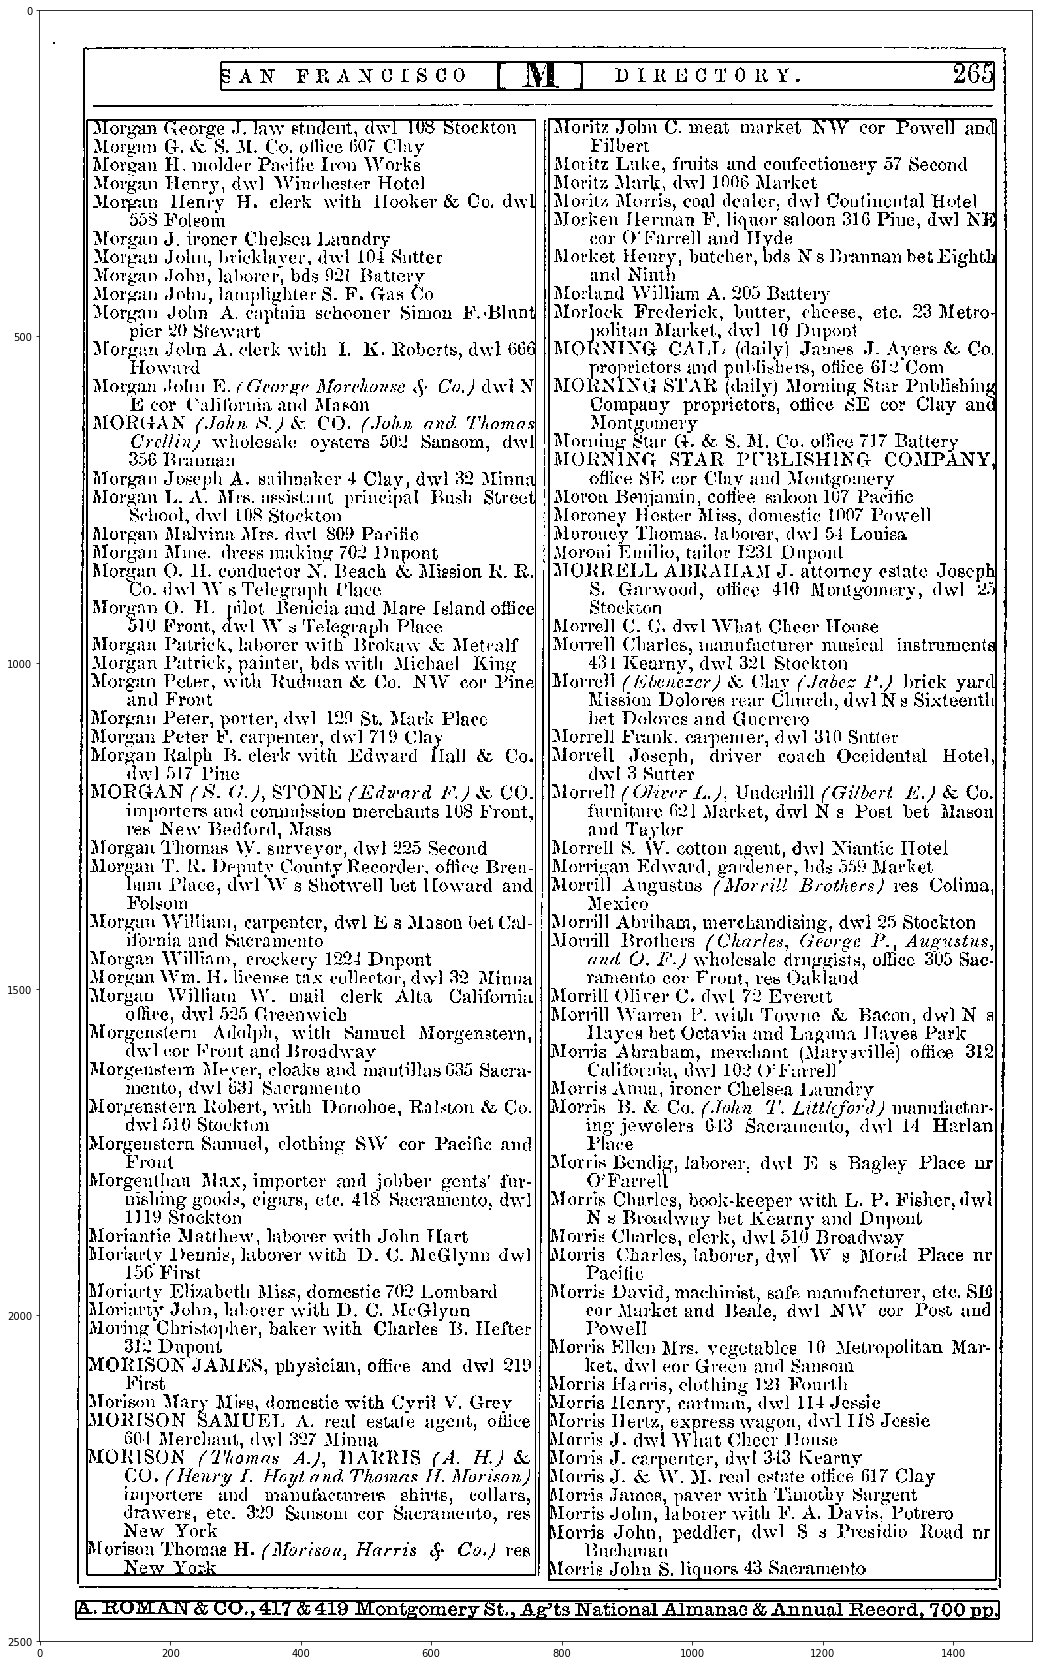

In [127]:
pagenum = 350
img = pdf_page_to_img(src_pdf, pagenum)
blocks = categorizeTwoColumnBlocks(contents[pagenum])
plt.rcParams["figure.figsize"] = (50,30)
try:
    img_mergedBlocks = drawMergedBlocks(img, blocks)
except:
    img_mergedBlocks = img    
plt.imshow(img_mergedBlocks,cmap='gray')
plt.show()

In [132]:
blocks['paragraphs']['header']

['SAN FRANCISCO', '[ Mo] pirecrory.', '2 6 5']

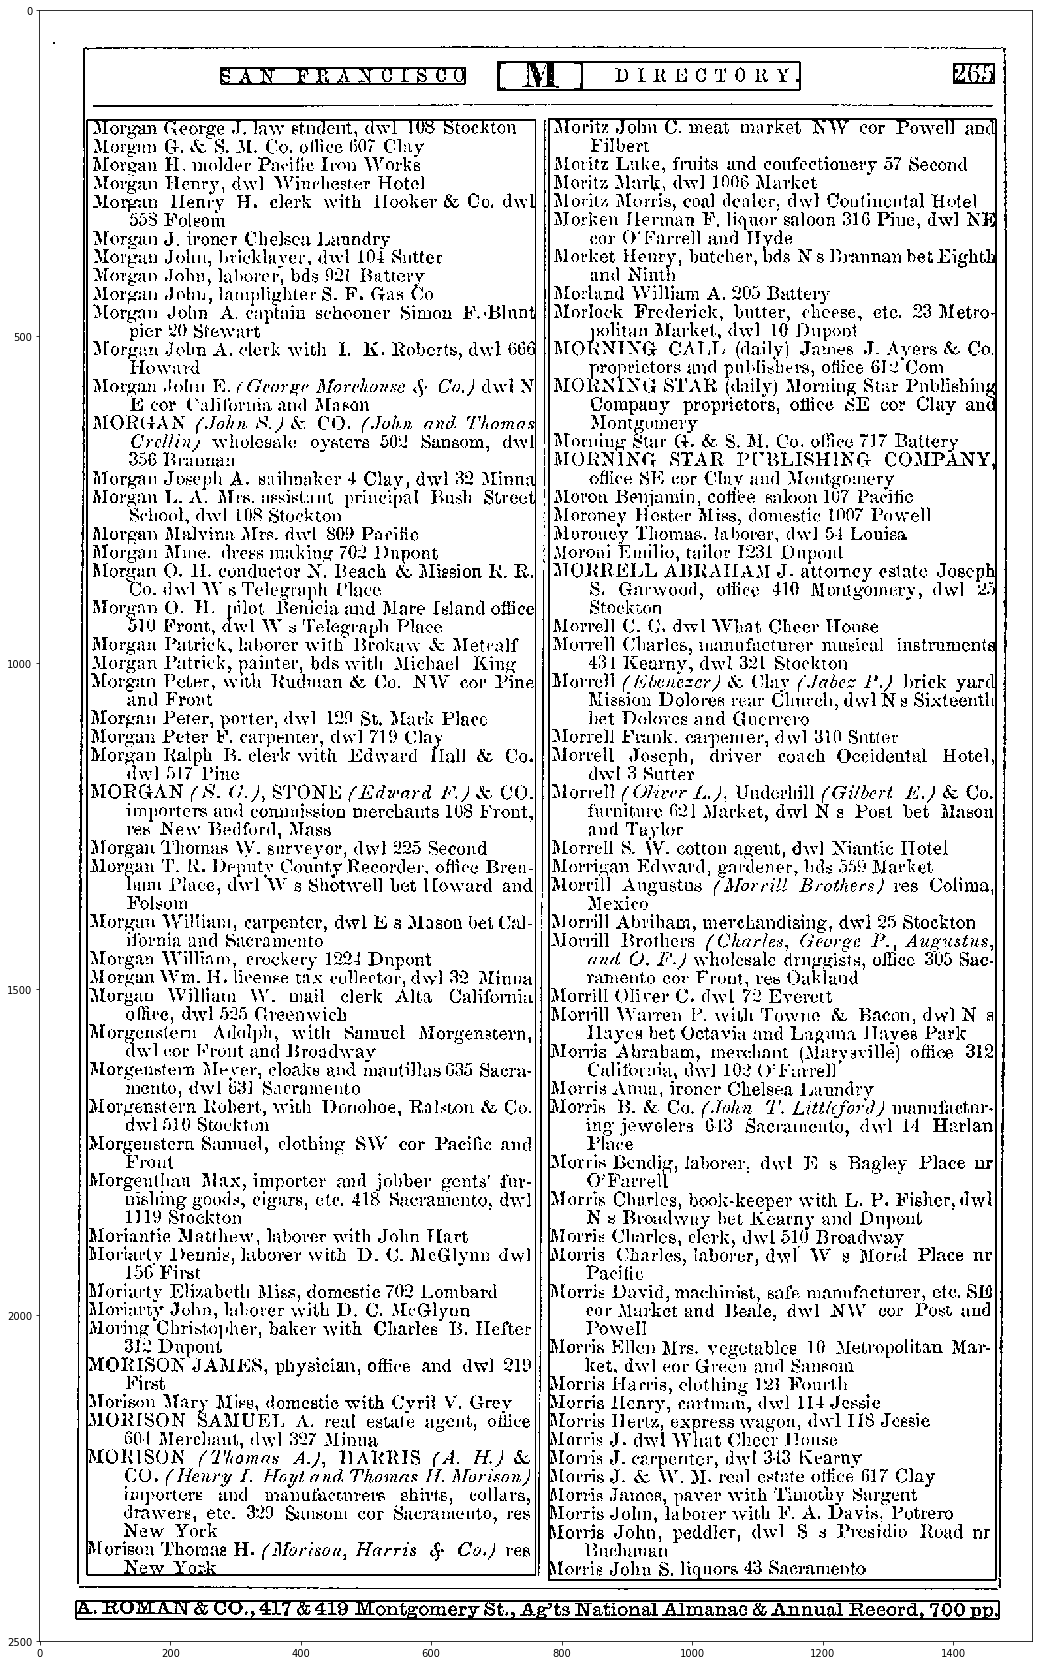

In [129]:
pagenum = 350
img = pdf_page_to_img(src_pdf, pagenum)
blocks = categorizeTwoColumnBlocks(contents[pagenum])
plt.rcParams["figure.figsize"] = (50,30)
try:
    img_blocks = drawBlocks(img, contents[pagenum])
except:
    img_blocks = img    
plt.imshow(img_blocks,cmap='gray')
plt.show()

In [126]:
contents[350]

{'blockstats':        n_par  n_line  top_at  bottom_at  left_at  right_at
 block                                                     
 2          1       2      88        113      279       652
 3          1       3      79        122      702      1165
 4          1       1      82        112     1401      1462
 6         48     469     168       2398       73       760
 9         50     469     167       2406      780      1465
 11         1      16    2438       2466       56      1470,
 'paragraphs': {2: ['SAN FRANCISCO'],
  3: ['[ Mo] pirecrory.'],
  4: ['2 6 5'],
  6: ['Morgan George J. law stndent, dw] 108 Stockton',
   'Morgan G. & 8. M. Co. office 607 Clay',
   'Morgan H. molder Pacific Iron Works',
   'Morgan Henry, dw] Winchester Hotel',
   'Morgan Ilenry H. clerk with Hooker & Co. dwl 598 Folzom',
   'Morgan J. ironer Chelsea Laundry',
   'Morgan John, bricklayer, dwl 104 Sutter',
   'Morgan Joba, laborer, bds 921 Battery',
   'Morgan John, lamplighter 8. F. Gas Co',
   'Mo

In [97]:
blocks

{'mergedblocks': {'header': {'top_at': 79,
   'bottom_at': 122,
   'left_at': 279,
   'right_at': 1462,
   'width': 1183,
   'height': 43},
  'footer': {'top_at': 2438,
   'bottom_at': 2466,
   'left_at': 56,
   'right_at': 1470,
   'width': 1414,
   'height': 28},
  'leftcol': {'top_at': 168,
   'bottom_at': 2398,
   'left_at': 73,
   'right_at': 760,
   'width': 687,
   'height': 2230},
  'rightcol': {'top_at': 167,
   'bottom_at': 2406,
   'left_at': 780,
   'right_at': 1465,
   'width': 685,
   'height': 2239}},
 'blockstats': {'header':        n_par  n_line  top_at  bottom_at  left_at  right_at
  block                                                     
  2          1       2      88        113      279       652
  3          1       3      79        122      702      1165
  4          1       1      82        112     1401      1462,
  'footer':        n_par  n_line  top_at  bottom_at  left_at  right_at
  block                                                     
  11         1  

In [68]:
contents[0].keys()

dict_keys(['blockstats', 'paragraphs', 'data', 'boxes', 'pagenum'])

In [92]:
blocks

{'mergedblocks': {'header': {'top_at': 79,
   'bottom_at': 122,
   'left_at': 279,
   'right_at': 1462,
   'width': 1183,
   'height': 43},
  'footer': {'top_at': 2438,
   'bottom_at': 2466,
   'left_at': 56,
   'right_at': 1470,
   'width': 1414,
   'height': 28},
  'leftcol': {'top_at': 168,
   'bottom_at': 2398,
   'left_at': 73,
   'right_at': 760,
   'width': 687,
   'height': 2230},
  'rightcol': {'top_at': 167,
   'bottom_at': 2406,
   'left_at': 780,
   'right_at': 1465,
   'width': 685,
   'height': 2239}},
 'blocks': {'header':        n_par  n_line  top_at  bottom_at  left_at  right_at
  block                                                     
  2          1       2      88        113      279       652
  3          1       3      79        122      702      1165
  4          1       1      82        112     1401      1462,
  'footer':        n_par  n_line  top_at  bottom_at  left_at  right_at
  block                                                     
  11         1      